Loaded dataset shape: (119390, 33)
Using numeric columns: ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']
Preprocessed feature matrix shape: (119390, 13)


C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(



LOF Label Counts:
LOF_Label
Normal     117017
Outlier      2373
Name: count, dtype: int64
PCA(10) shape (for DBSCAN): (119390, 10)

DBSCAN chosen eps: 0.7644827464484559
DBSCAN Label Counts:
DBSCAN_Label
Normal     115271
Outlier      4119
Name: count, dtype: int64

LOF vs DBSCAN comparison:
DBSCAN   Normal  Outlier
LOF                     
Normal   112932     4085
Outlier    2339       34


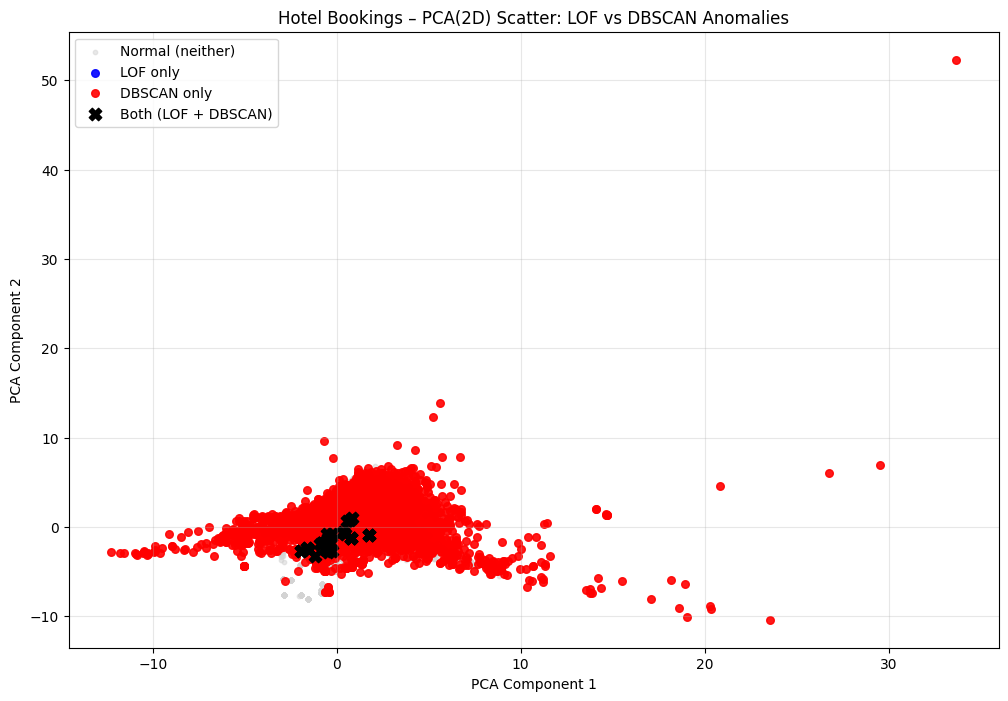


Saved results to: hotel_bookings_anomaly_lof_dbscan.csv

Top 10 LOF anomalies by score:
              hotel    adr  lead_time  adults  children  babies     LOF_Score  \
31561  Resort Hotel  340.0      128.0     2.0       0.0     0.0  3.163538e+10   
31568  Resort Hotel  325.0      128.0     2.0       0.0     0.0  2.972009e+10   
31577  Resort Hotel  305.0      128.0     2.0       0.0     0.0  2.926574e+10   
48611    City Hotel  130.0      161.0     3.0       0.0     0.0  1.922112e+10   
48599    City Hotel  130.0      161.0     3.0       0.0     0.0  1.922112e+10   
48574    City Hotel  130.0      161.0     3.0       0.0     0.0  1.922112e+10   
48537    City Hotel  130.0      161.0     3.0       0.0     0.0  1.922112e+10   
68308    City Hotel  160.0      164.0     1.0       0.0     0.0  1.561632e+10   
81881    City Hotel    0.0      178.0     1.0       0.0     0.0  1.487280e+10   
81882    City Hotel    0.0      178.0     1.0       0.0     0.0  1.487280e+10   

      LOF_Label DBS

In [9]:
"""
Anomaly Detection on Hotel Bookings Dataset (GitHub)
Methods: LOF (Local Outlier Factor) + DBSCAN
+ 2D PCA visualization comparing LOF vs DBSCAN

Dataset:
https://github.com/swapnilsaurav/Dataset/blob/master/hotel_bookings.csv
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


def load_data() -> pd.DataFrame:
    url = "https://raw.githubusercontent.com/swapnilsaurav/Dataset/master/hotel_bookings.csv"
    return pd.read_csv(url)


def pick_numeric_features(df: pd.DataFrame) -> list:
    """
    Select a stable set of numeric columns for anomaly detection.
    (Using numeric-only keeps the program robust across sklearn versions and avoids huge one-hot matrices.)
    """
    preferred = [
        "lead_time",
        "adr",
        "stays_in_weekend_nights",
        "stays_in_week_nights",
        "adults",
        "children",
        "babies",
        "previous_cancellations",
        "previous_bookings_not_canceled",
        "booking_changes",
        "days_in_waiting_list",
        "required_car_parking_spaces",
        "total_of_special_requests",
    ]
    cols = [c for c in preferred if c in df.columns]
    if not cols:
        raise ValueError("No expected numeric columns found in the dataset.")
    return cols


def choose_dbscan_eps(X: np.ndarray, k: int = 10, percentile: float = 95) -> float:
    """
    Heuristic for eps:
    - compute distance to the k-th nearest neighbor for each point
    - choose eps as a high percentile of those distances
    """
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    kth_dist = distances[:, -1]
    return float(np.percentile(kth_dist, percentile))


def main():
    # -------------------------
    # 1) Load data
    # -------------------------
    df = load_data()
    print("Loaded dataset shape:", df.shape)

    # -------------------------
    # 2) Prepare numeric feature matrix
    # -------------------------
    numeric_cols = pick_numeric_features(df)
    print("Using numeric columns:", numeric_cols)

    preprocess = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    X = preprocess.fit_transform(df[numeric_cols])
    print("Preprocessed feature matrix shape:", X.shape)

    # -------------------------
    # 3) LOF
    # -------------------------
    lof = LocalOutlierFactor(
        n_neighbors=35,
        contamination=0.02
    )
    lof_pred = lof.fit_predict(X)  # 1 normal, -1 outlier

    # LOF score: more negative => more anomalous; invert to make "bigger = more anomalous"
    lof_score = -lof.negative_outlier_factor_

    df["LOF_Label"] = np.where(lof_pred == -1, "Outlier", "Normal")
    df["LOF_Score"] = lof_score

    print("\nLOF Label Counts:")
    print(df["LOF_Label"].value_counts())

    # -------------------------
    # 4) PCA for DBSCAN (and for visualization)
    # -------------------------
    # DBSCAN struggles in high dimensions; PCA helps distance-based clustering behave better
    pca_10 = PCA(n_components=10, random_state=42)
    X_pca10 = pca_10.fit_transform(X)
    print("PCA(10) shape (for DBSCAN):", X_pca10.shape)

    # -------------------------
    # 5) DBSCAN
    # -------------------------
    eps = choose_dbscan_eps(X_pca10, k=10, percentile=95)
    dbscan = DBSCAN(
        eps=eps,
        min_samples=10
    )
    db_labels = dbscan.fit_predict(X_pca10)  # -1 means noise (outlier)

    df["DBSCAN_Label"] = np.where(db_labels == -1, "Outlier", "Normal")
    df["DBSCAN_Cluster"] = db_labels

    print("\nDBSCAN chosen eps:", eps)
    print("DBSCAN Label Counts:")
    print(df["DBSCAN_Label"].value_counts())

    # -------------------------
    # 6) Comparison table
    # -------------------------
    print("\nLOF vs DBSCAN comparison:")
    comparison = pd.crosstab(df["LOF_Label"], df["DBSCAN_Label"], rownames=["LOF"], colnames=["DBSCAN"])
    print(comparison)

    # -------------------------
    # 7) 2D PCA visualization (LOF vs DBSCAN)
    # -------------------------
    pca_2 = PCA(n_components=2, random_state=42)
    X_2d = pca_2.fit_transform(X)

    df["PCA1"] = X_2d[:, 0]
    df["PCA2"] = X_2d[:, 1]

    df["LOF_Outlier"] = df["LOF_Label"] == "Outlier"
    df["DBSCAN_Outlier"] = df["DBSCAN_Label"] == "Outlier"
    df["Both_Outlier"] = df["LOF_Outlier"] & df["DBSCAN_Outlier"]

    plt.figure(figsize=(12, 8))

    # Normal (neither flagged)
    mask_normal = ~df["LOF_Outlier"] & ~df["DBSCAN_Outlier"]
    plt.scatter(df.loc[mask_normal, "PCA1"], df.loc[mask_normal, "PCA2"],
                c="lightgray", s=10, alpha=0.5, label="Normal (neither)")

    # LOF-only
    mask_lof_only = df["LOF_Outlier"] & ~df["DBSCAN_Outlier"]
    plt.scatter(df.loc[mask_lof_only, "PCA1"], df.loc[mask_lof_only, "PCA2"],
                c="blue", s=30, alpha=0.9, label="LOF only")

    # DBSCAN-only
    mask_db_only = ~df["LOF_Outlier"] & df["DBSCAN_Outlier"]
    plt.scatter(df.loc[mask_db_only, "PCA1"], df.loc[mask_db_only, "PCA2"],
                c="red", s=30, alpha=0.9, label="DBSCAN only")

    # Both
    mask_both = df["Both_Outlier"]
    plt.scatter(df.loc[mask_both, "PCA1"], df.loc[mask_both, "PCA2"],
                c="black", s=80, marker="X", label="Both (LOF + DBSCAN)")

    plt.title("Hotel Bookings – PCA(2D) Scatter: LOF vs DBSCAN Anomalies")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # -------------------------
    # 8) Save results
    # -------------------------
    out_path = "hotel_bookings_anomaly_lof_dbscan.csv"
    df.to_csv(out_path, index=False)
    print(f"\nSaved results to: {out_path}")

    # Optional: show top LOF anomalies
    cols_to_show = [c for c in ["hotel", "adr", "lead_time", "adults", "children", "babies"] if c in df.columns]
    print("\nTop 10 LOF anomalies by score:")
    print(df.sort_values("LOF_Score", ascending=False)[cols_to_show + ["LOF_Score", "LOF_Label", "DBSCAN_Label"]].head(10))


if __name__ == "__main__":
    main()
